# Learn $f$ against true dynamics as weight initialization, then learn both $f$ and $g$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from tqdm.auto import tqdm
from stabnode.utils import set_global_seed
from data.budworm import simulate_trials, budworm_steady_states


seed = 1234
set_global_seed(seed=seed)
device = 'cpu'
folder = "figures"
savefigs = False

In [2]:
k=8.5

In [3]:
xs_traj = []
ts = []

x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs_traj.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

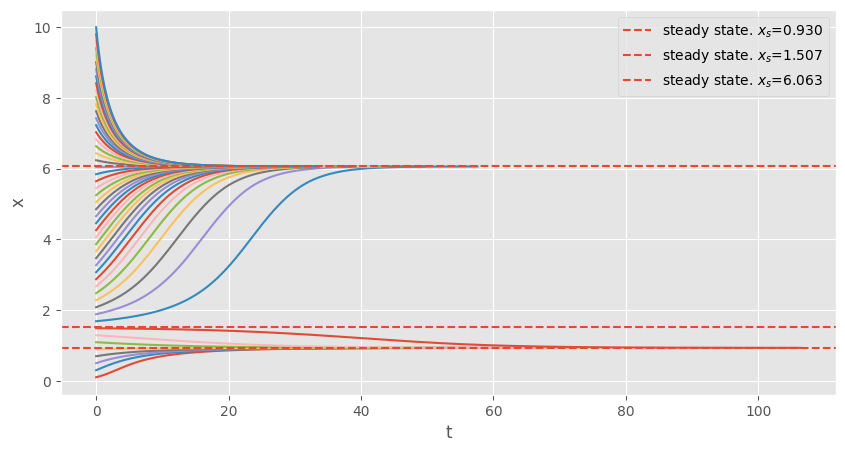

In [4]:
# expected steady states for fixed k and r
steady_states = budworm_steady_states(k,r=0.56)

plt.figure(figsize=(10,5))
for ti, xi in zip(ts, xs_traj):
    plt.plot(ti,xi)
for x_steady_state in steady_states:
    plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
if savefigs:
    name = f"trajectories_k_{k:.4f}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

## Proprocess data

In [5]:
import torch
from sklearn.preprocessing import MinMaxScaler
from stabnode.data import TrialsDataset

In [6]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs_traj).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs_traj]

In [7]:
xs_torch = [torch.tensor(xi,dtype=torch.float32,device=device) for xi in xs_scaled]
ts_torch = [torch.tensor(ti,dtype=torch.float32,device=device) for ti in ts]

In [8]:
train_dataset = TrialsDataset(x_trials=xs_torch, t_trials=ts_torch)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=1,num_workers=0)

In [9]:
from data.budworm import f_true, g_true

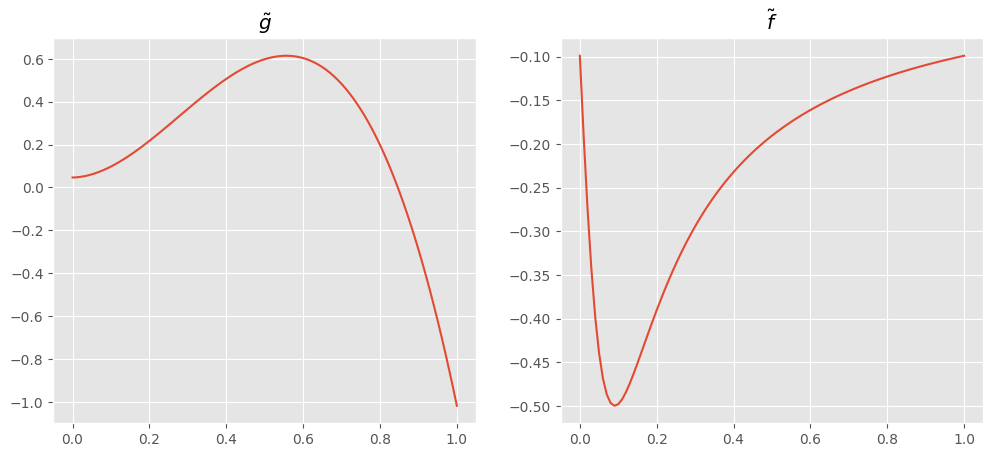

In [10]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).reshape(-1)

f_true_arr = f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).reshape(-1)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x_lin, g_true_arr)
ax1.set_title(r"$\tilde{g}$")
ax2.plot(x_lin, f_true_arr)
ax2.set_title(r"$\tilde{f}$")
plt.show()

In [11]:
g_true_arr.min(), g_true_arr.max(), f_true_arr.min(), f_true_arr.max()

(-1.0183006535947712,
 0.6143380935111112,
 -0.4999795669299085,
 -0.09900990099009901)

# Pretrain $\tilde f$

In [12]:
from stabnode.node import FeluSigmoidMLP, GeluSigmoidMLPfeaturized
import torch
import torch.nn as nn

In [13]:
x_lin_torch = torch.tensor(x_lin, dtype=torch.float32, device=device)

In [14]:
f = FeluSigmoidMLP(dims = [1,10,10,1], activation = torch.nn.SiLU(), lower_bound = -0.5, upper_bound = -0.1)

In [15]:
f_epochs = 20000
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)
scheduler = None
print_every = 200

In [16]:
xs = x_lin_torch.to(device)  

f_true_torch = torch.tensor(f_true_arr, dtype=torch.float32, device=device)


losses = []
lrs = []

f.train()
for epoch in tqdm(range(f_epochs)):
    opt.zero_grad()

    f_pred = [f(xi.reshape(-1,1)).reshape(-1) for xi in xs]
    f_pred = torch.cat(f_pred)

    # Loss
    loss = loss_criteria(f_true_torch, f_pred)

    # Backward + step
    loss.backward()
    opt.step()

    # Record
    epoch_loss = loss.item()
    if scheduler is not None:
        scheduler.step(epoch_loss)
    cur_lr = opt.param_groups[0]['lr']
    lrs.append(cur_lr)
    losses.append(epoch_loss)
    if epoch <= 5 or epoch % print_every ==0 or epoch == f_epochs-1:
        print(f"epoch {epoch}. Loss = {epoch_loss:.10f}. lr = {cur_lr:.10f}.")

  0%|          | 0/20000 [00:00<?, ?it/s]

epoch 0. Loss = 0.0240034554. lr = 0.0100000000.
epoch 1. Loss = 0.0232461039. lr = 0.0100000000.
epoch 2. Loss = 0.0224853270. lr = 0.0100000000.
epoch 3. Loss = 0.0217245836. lr = 0.0100000000.
epoch 4. Loss = 0.0209663976. lr = 0.0100000000.
epoch 5. Loss = 0.0202113185. lr = 0.0100000000.
epoch 200. Loss = 0.0027084330. lr = 0.0100000000.
epoch 400. Loss = 0.0024040691. lr = 0.0100000000.
epoch 600. Loss = 0.0009294963. lr = 0.0100000000.
epoch 800. Loss = 0.0001622509. lr = 0.0100000000.
epoch 1000. Loss = 0.0001027071. lr = 0.0100000000.
epoch 1200. Loss = 0.0000865190. lr = 0.0100000000.
epoch 1400. Loss = 0.0000783648. lr = 0.0100000000.
epoch 1600. Loss = 0.0000726623. lr = 0.0100000000.
epoch 1800. Loss = 0.0000681258. lr = 0.0100000000.
epoch 2000. Loss = 0.0000643416. lr = 0.0100000000.
epoch 2200. Loss = 0.0000610988. lr = 0.0100000000.
epoch 2400. Loss = 0.0000582773. lr = 0.0100000000.
epoch 2600. Loss = 0.0000557738. lr = 0.0100000000.
epoch 2800. Loss = 0.0000541227. l

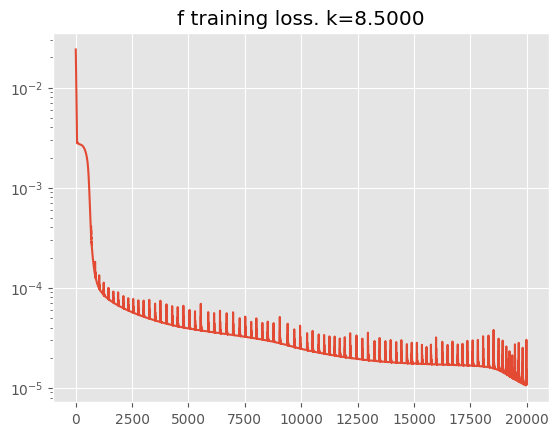

In [17]:
plt.plot(losses)
plt.yscale("log")
plt.title(f"f training loss. k={k:.4f}")
if savefigs:
    name = f"f_loss_k_{k:.4f}_epochs_{f_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

In [18]:
f_eval = f.eval()

with torch.no_grad():
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)

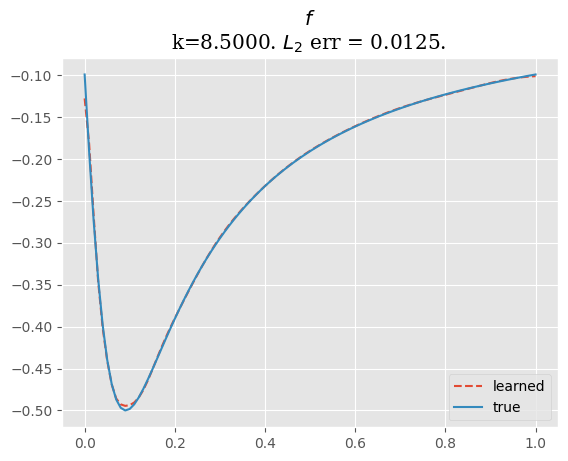

In [19]:
plt.plot(x_lin_torch.detach(),f_pred, linestyle='--',label='learned')
plt.plot(x_lin, f_true_arr,label='true')
err = np.linalg.norm(f_true_arr - f_pred.numpy()) / np.linalg.norm(f_true_arr)
plt.legend()
plt.title(rf"$f$"+"\n"+rf"k={k:.4f}. $L_2$ err = {err:.4f}. ", family='serif')
if savefigs:
    name = f"f_learned_k_{k:.4f}_f_epochs_{f_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

## Train on both $\tilde f$ and $\tilde g$

In [20]:
from stabnode.node import StabNODE, model_trainer, GeluSigmoidMLPfeaturized

In [21]:
g = GeluSigmoidMLPfeaturized(
    dims = [5+1,10,10,1], 
    activation = torch.nn.SiLU(), 
    lower_bound = g_true_arr.min(), 
    upper_bound = g_true_arr.max(), 
    freq_sample_step = 1,
    feat_lower_bound=0,
    feat_upper_bound=1
    )

g.train()
f.train()

model = StabNODE(f,g).to(device)

In [22]:
n_epochs = 500
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)

model, log_history = model_trainer(
    model=model,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=n_epochs,
    control=lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0),
    min_improvement=1e-6,
    patience=300,
    solve_method='tsit5',
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    print_every=10,
    _precision=10,
    train_dyn = True,
    exp_loss_time_decay = 1.0
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Loss: 0.0002283892. time = 20.0546720028s. lr = 0.0100000000
Epoch 1: Loss: 0.0000885808. time = 14.6835429668s. lr = 0.0100000000
Epoch 2: Loss: 0.0001021282. time = 13.8695266247s. lr = 0.0100000000
Epoch 3: Loss: 0.0000991549. time = 13.9302330017s. lr = 0.0100000000
Epoch 4: Loss: 0.0000952940. time = 13.0873069763s. lr = 0.0100000000
Epoch 5: Loss: 0.0000870305. time = 13.1272189617s. lr = 0.0100000000
Epoch 10: Loss: 0.0000642484. time = 15.3549339771s. lr = 0.0100000000
Epoch 20: Loss: 0.0000578113. time = 14.5002839565s. lr = 0.0100000000
Epoch 30: Loss: 0.0000620754. time = 14.6514358521s. lr = 0.0100000000
Epoch 40: Loss: 0.0000502310. time = 15.6861412525s. lr = 0.0100000000
Epoch 50: Loss: 0.0000376380. time = 13.4638979435s. lr = 0.0100000000
Epoch 60: Loss: 0.0000097663. time = 15.2909557819s. lr = 0.0100000000
Epoch 70: Loss: 0.0000034651. time = 13.7012810707s. lr = 0.0100000000
Epoch 80: Loss: 0.0000014381. time = 15.1652541161s. lr = 0.0100000000
Epoch 90: Lo

In [23]:
print(log_history["stopping_criteria"])

early-stoppage


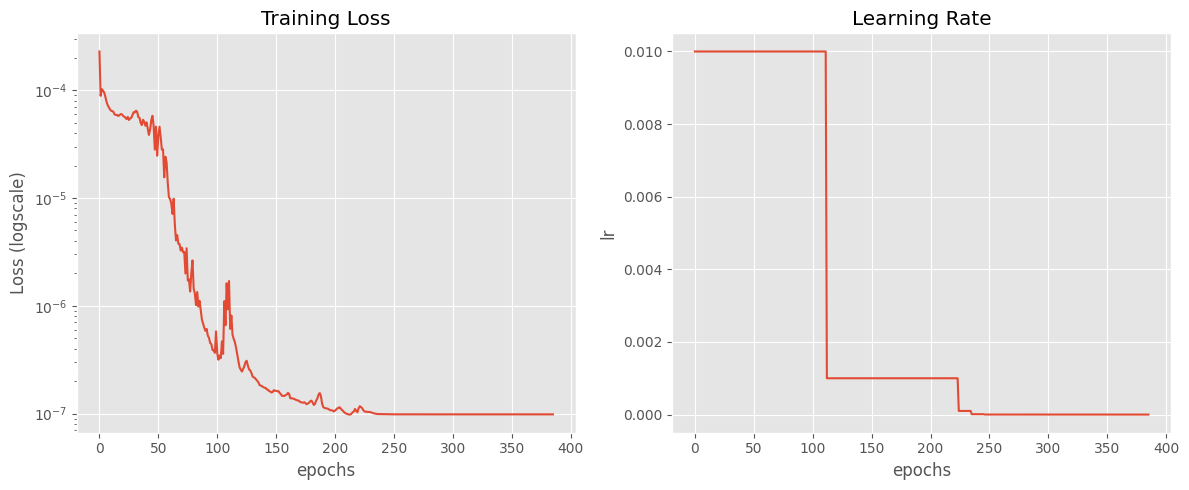

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.set_title("Training Loss")
ax1.plot(log_history["losses"])
ax1.set_yscale('log')
ax1.set_xlabel("epochs")
ax1.set_ylabel("Loss (logscale)")

ax2.set_title("Learning Rate")
ax2.plot(log_history['lr_hist'])
ax2.set_xlabel('epochs')
ax2.set_ylabel("lr")

plt.tight_layout()
plt.show()

## Learned dynamics

In [25]:
from torchode import solve_ivp
from tqdm.auto import tqdm

In [26]:
g_eval = model.g.eval()
f_eval = model.f.eval()

model_eval = StabNODE(f_eval,g_eval)

In [27]:
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(k,r=0.56)).reshape(-1,1)).reshape(-1)

  0%|          | 0/51 [00:00<?, ?it/s]

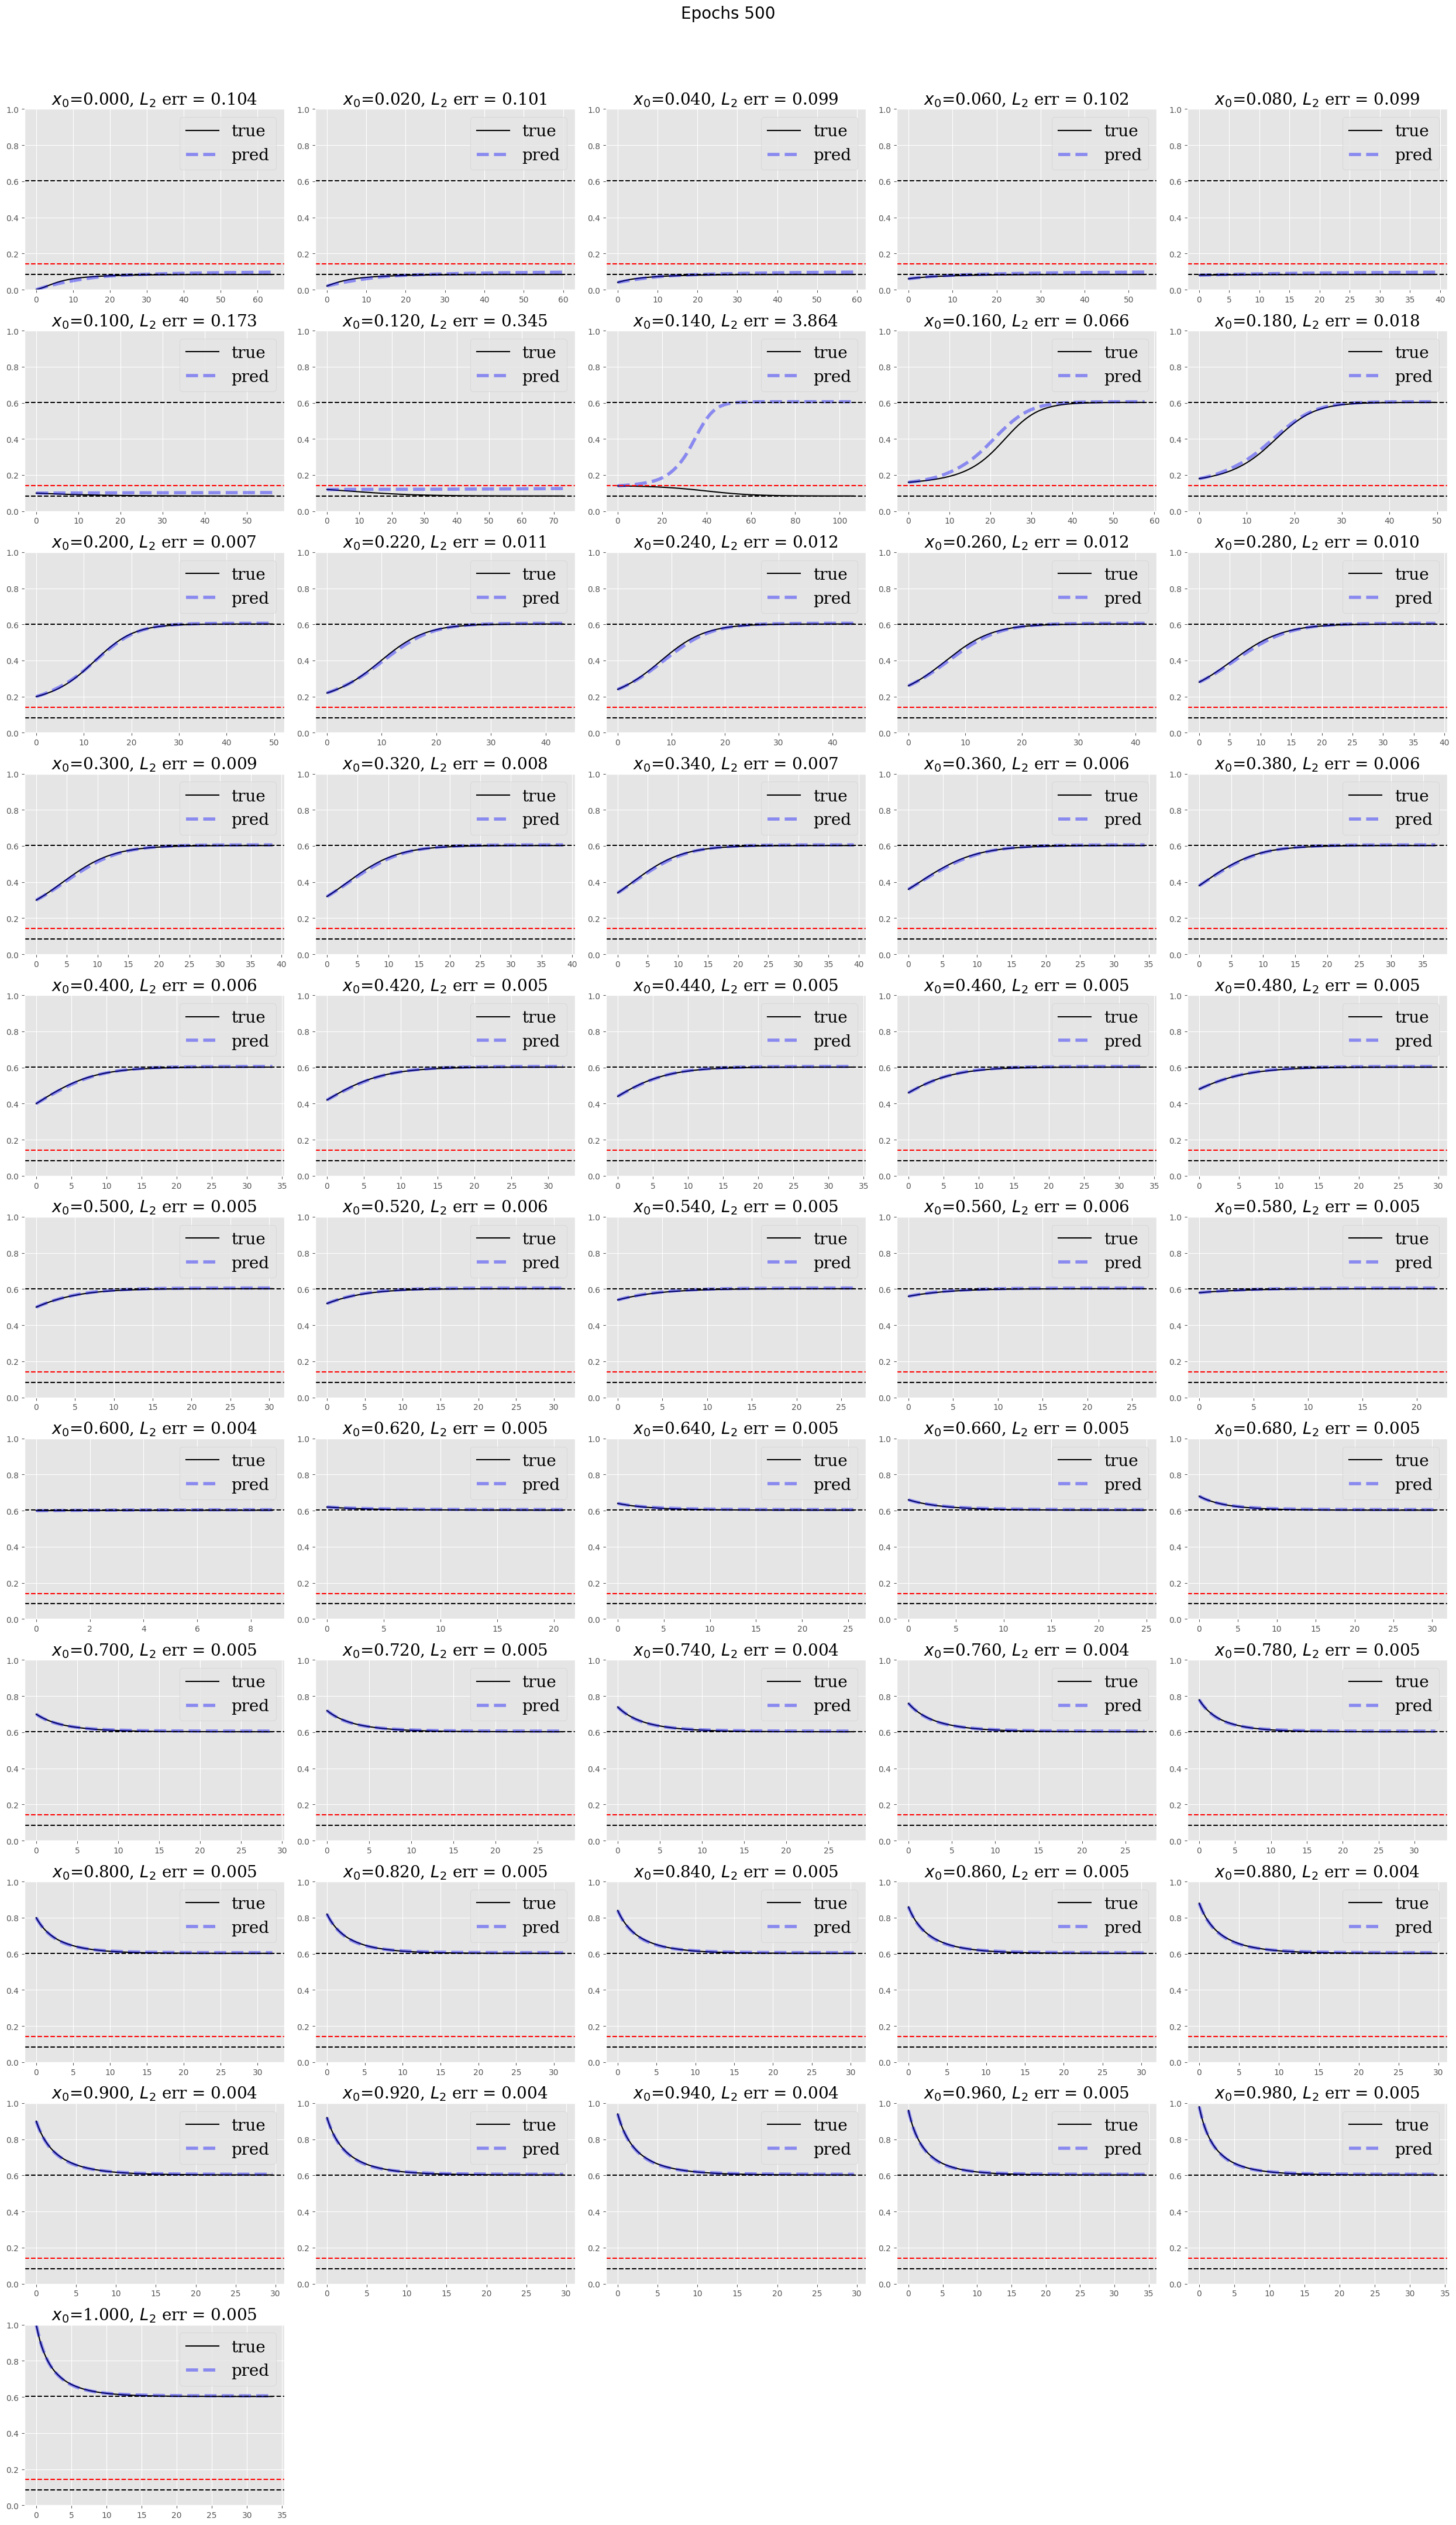

In [28]:
cols = 5
rows = int(np.ceil(len(train_dataset)/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(len(train_dataset))):
        ax = axs[idx]
        xi, ti, x0i = train_dataset[idx]

        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i.reshape(-1,1),
            t_eval=ti,
            method=solve_method
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(train_dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"Epochs {n_epochs}", size=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


## Learned $\tilde f$ and $\tilde g$

In [29]:
from data.budworm import g_true, f_true

In [30]:
x_lin = np.linspace(0,1,101)
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])

x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

f_true_arr =  f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).squeeze()

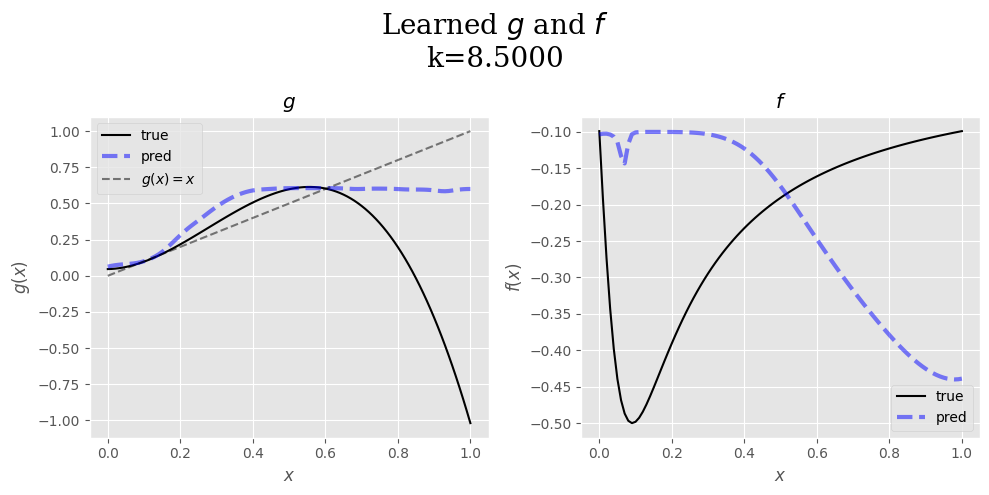

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(x_lin, g_true_arr,label='true',c='black')
ax1.plot(x_lin_torch, g_pred, label='pred', linestyle='--', c='blue', alpha=0.5, lw=3)
ax1.plot(x_lin, x_lin, c='black', linestyle='--',alpha=0.5,label=r"$g(x)=x$")
ax1.set_title(r"$g$")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$g(x)$")
# ax1.set_ylim(-0.1,1)
ax1.legend()

ax2.plot(x_lin, f_true_arr, label='true', c='black')
ax2.plot(x_lin_torch, f_pred, label='pred',linestyle='--',c='blue',lw=3,alpha=0.5)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$f(x)$")
ax2.set_title(r"$f$")
ax2.legend()
plt.suptitle(r"Learned $g$ and $f$"+f"\nk={k:.4f}", family='serif', size=20)
plt.tight_layout()
plt.show()